In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json
from tqdm.notebook import tqdm
import sys
import corner
import matplotlib.image as mpimg

sys.path.append("../")

import tdpy_mod as tdpy

from binary_planets.sim import get_hill_radius

%load_ext autoreload
%autoreload 2

%matplotlib inline


In [2]:
def gen_arr(config, bin=True, n=12000, secondary=True):
    n_secondary = config["n_secondary"]
    l = bin*len(config["binary"].keys()) + secondary*n_secondary*len(config["secondary_0"].keys()) + 2
    arr = np.zeros((n, l))*np.nan
    keys = []
    keys.append("stable")
    keys.append("m_star")

    if secondary:
        for i in range(0, n_secondary):
            for key in config["secondary_0"].keys():
                keys.append(f"{i}/{key}")
    if bin:
        for key in config["binary"].keys():
            keys.append(f"bin/{key}")
    
    
    return arr, keys




def add_to_array(arr, config, keys, i, stable, bin=True, n=12000, secondary=True):
    if not np.any(arr):
        arr, keys = gen_arr(config, bin=bin, n=n, secondary=secondary)
        
    n_secondary = config["n_secondary"]
    arr[i, 0] = stable

    arr[i, 1] = config["m_star"]
    j = 2
    
    if secondary:
        for k in range(0, n_secondary):
            for key in config["secondary_0"].keys():
                arr[i, j] = config[f"secondary_{k}"][key]
                j += 1
    if bin:
        for key in config["binary"].keys():
            arr[i, j] = config["binary"][key]
            j += 1
    
    
    return arr, keys
    

In [3]:

run_systems = np.load("../data/compact_systems_run_composite.npy", allow_pickle=True)
names = [sys["name"] for sys in run_systems]
names = ["Kepler-342"]

is_binary = True

dir = "bin_7"
arr_t = None
stable_t = None
stable_omega = []
unstable_omega = []
for system in names:
    try:
        arr = None
        keys = None
        system_idx = np.where(np.array(names) == system)[0][0]


        j = 0
        stable = np.zeros(5000)

        for i in tqdm(range(0, 5000)):
            try:
                with open(f"../output/{dir}/{system}/{i}/config.json") as f:
                    cfg = json.load(f)
                    elements = np.load(f"../output/{dir}/{system}/{i}/elements.npy")
                    distances = np.load(f"../output/{dir}/{system}/{i}/distances.npy")
                    a_i = elements[0, :, 0]
                    a_f = elements[-1, :, 0]
                    
                    stable[i] = np.all(((a_i-a_f)/a_i) < 0.1)

                    if is_binary:
                        bin_e = cfg["binary"]["e"]
                        bin_a = a_i[1]
                        max_d = 1.1 * bin_a * (1 + bin_e)
                        if np.any(distances > max_d):
                            stable[i] = False
                            
                    
                    # stable[i] = cfg["secondary_0"]["omega"] < 0
                    arr, keys = add_to_array(arr, cfg, keys, j, stable[i], bin=is_binary, secondary=False)


#                 print(stable[i])
                if stable[i]:
                    stable_omega.append(cfg["secondary_0"]["omega"])
                else:
                    unstable_omega.append(cfg["secondary_0"]["omega"])
                j += 1

            except Exception as e:
                print(e)
                pass
        arr = arr[:j, :]
        stable = stable[:j]
        stable = np.logical_not(np.logical_not(stable))
        keys = np.array(keys)
        arr[:, 1:] += np.random.random((arr.shape[0], arr.shape[1]-1)) * 1e-20


        m_tot = arr[:, keys=="bin/m1"] + arr[:, keys=="bin/m2"]
        q = arr[:, keys=="bin/m1"] / m_tot
        arr[:, keys=="bin/m1"] = m_tot
        arr[:, keys=="bin/m2"] = q
        keys[keys=="bin/m1"] = "bin/m_tot"
        keys[keys=="bin/m2"] = "bin/q"

        hill_radius = get_hill_radius(arr[:, keys=="bin/a"], 
                                      arr[:, keys=="bin/e_sys"], 
                                      arr[:, keys=="bin/m_tot"], 
                                      arr[:, keys=="m_star"])
        arr[:, keys=="bin/d"] /= hill_radius

        arr[:, keys=="bin/a"] = (np.log(arr[:, keys=="bin/a"]/run_systems[system_idx]["gap"][0]) 
                                 / np.log(run_systems[system_idx]["gap"][1]/run_systems[system_idx]["gap"][0]))

        if not np.any(arr_t):
            arr_t = arr
            stable_t = stable
        else:
            arr_t = np.vstack([arr_t, arr])
            stable_t = np.hstack([stable_t, stable])
    except Exception as e:
        print(e)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
np.sum(stable_t), np.sum(~stable_t)

TypeError: bad operand type for unary ~: 'NoneType'

In [8]:
np.sum(stable_t), np.sum(~stable_t)

(363, 4637)

tdpy.util.plot_grid():
boolplotpies
True


ValueError: Invalid RGBA argument: 0.0

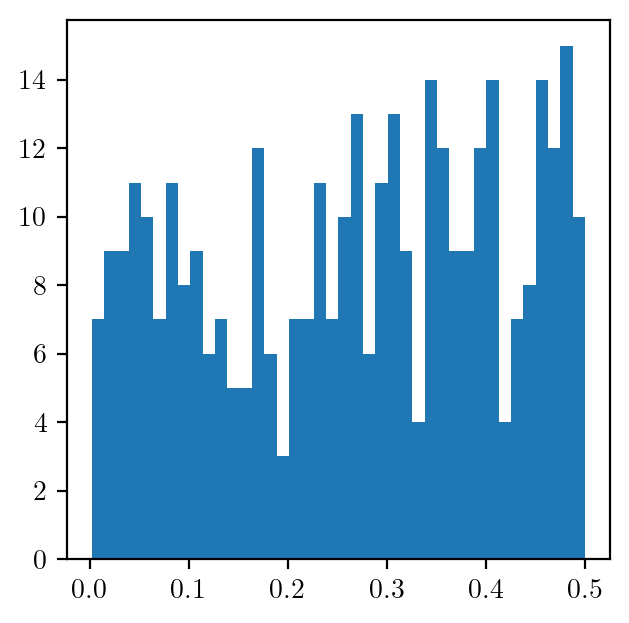

In [14]:
# idxs = np.array(["e" in key for key in keys])
# idxs = np.array([("stable" not in key) for key in keys])

good_keys = ['bin/q', 'bin/d', 'bin/e', 'bin/a', 'bin/e_sys',  'bin/inc', 'bin/bin_inc']

idxs = np.array([(key in good_keys) for key in keys])


param_labels = np.char.replace(np.array(keys)[idxs], "_", "-")



# labels of the populations
listlablpopl = ['stable', 'not stable']

# number of populations
numbpopl = len(listlablpopl)


# number of features
numbfeat = np.sum(idxs)

# generate samples


# labels of the parameters
listlablpara = []
for k in range(numbfeat):
    listlablpara.append([param_labels[k], ''])

typepgrp = 'both'
    
listcolrpopl = ["red", "gray"]
    
tdpy.plot_grid( 
               np.array(listlablpara),arr_t[arr_t[:, 0]==1, :][: ,idxs], listlablpopl=listlablpopl, typeplottdim='hist', 
               pathbase=f"../figs/cornerbin_only")
# plt.savefig("../figs/corner.pdf")


In [12]:
listlablpara

[['bin/q', ''],
 ['bin/d', ''],
 ['bin/e', ''],
 ['bin/a', ''],
 ['bin/e-sys', ''],
 ['bin/inc', ''],
 ['bin/bin-inc', '']]

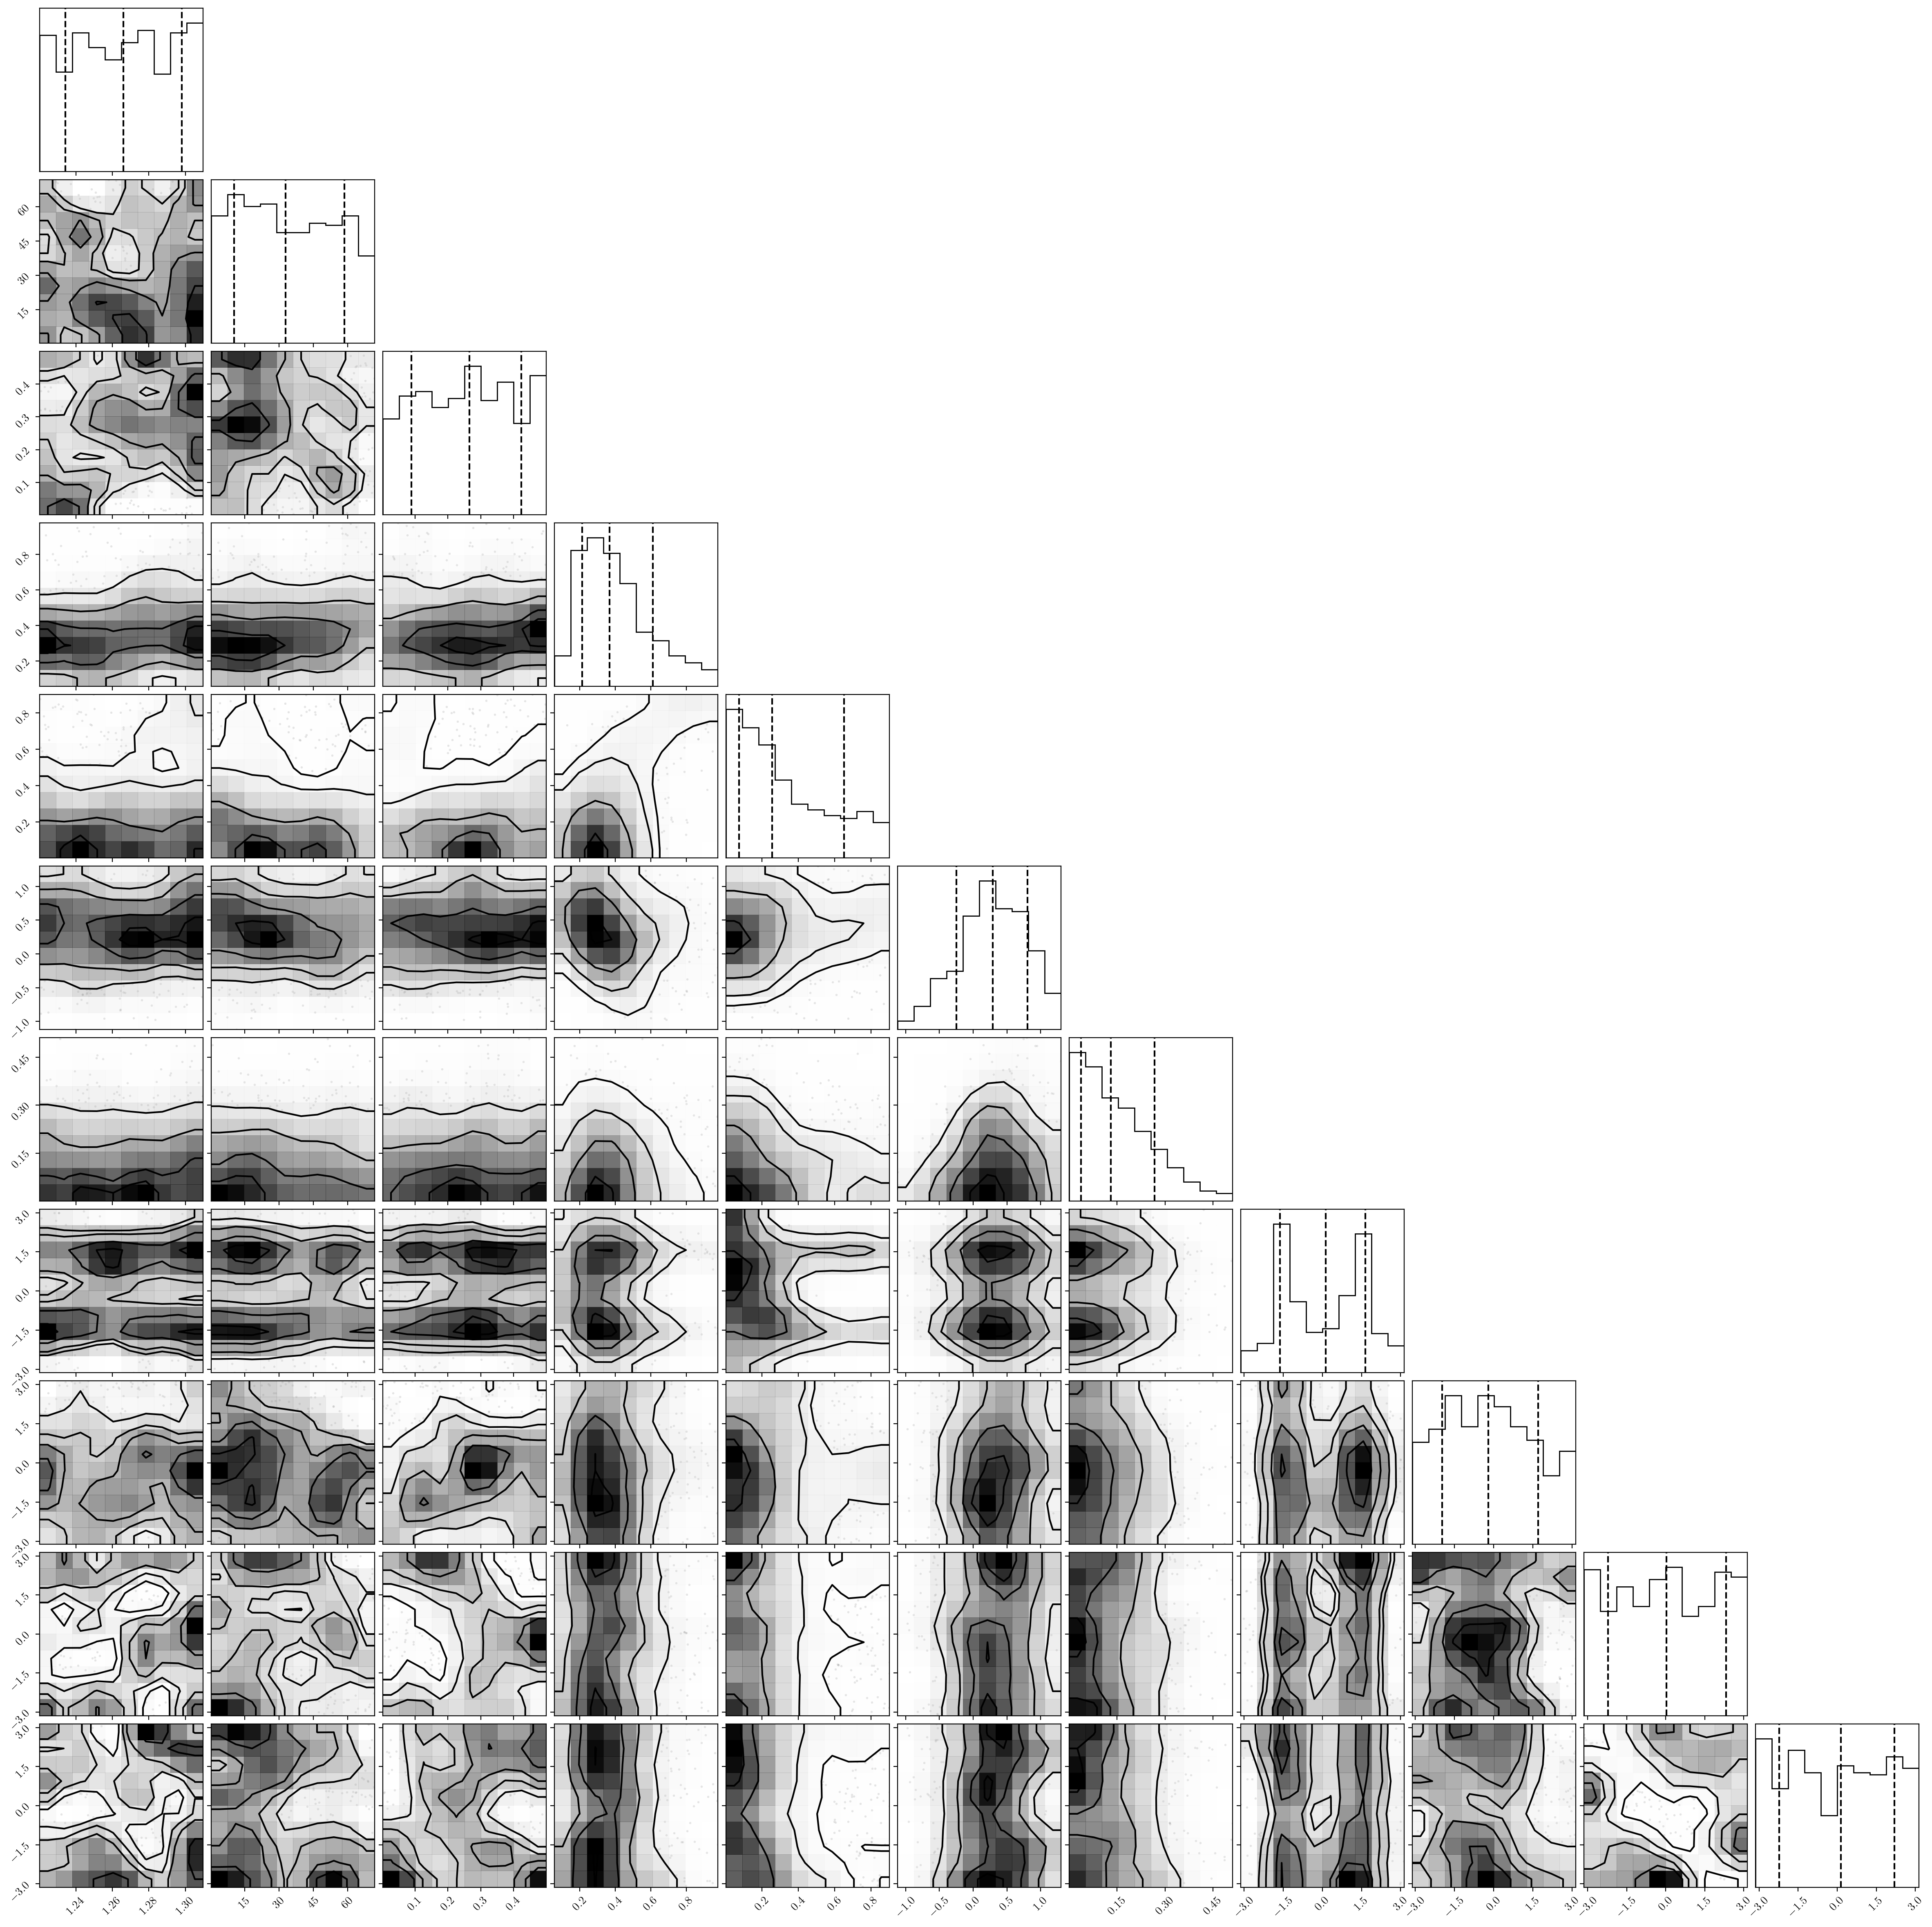

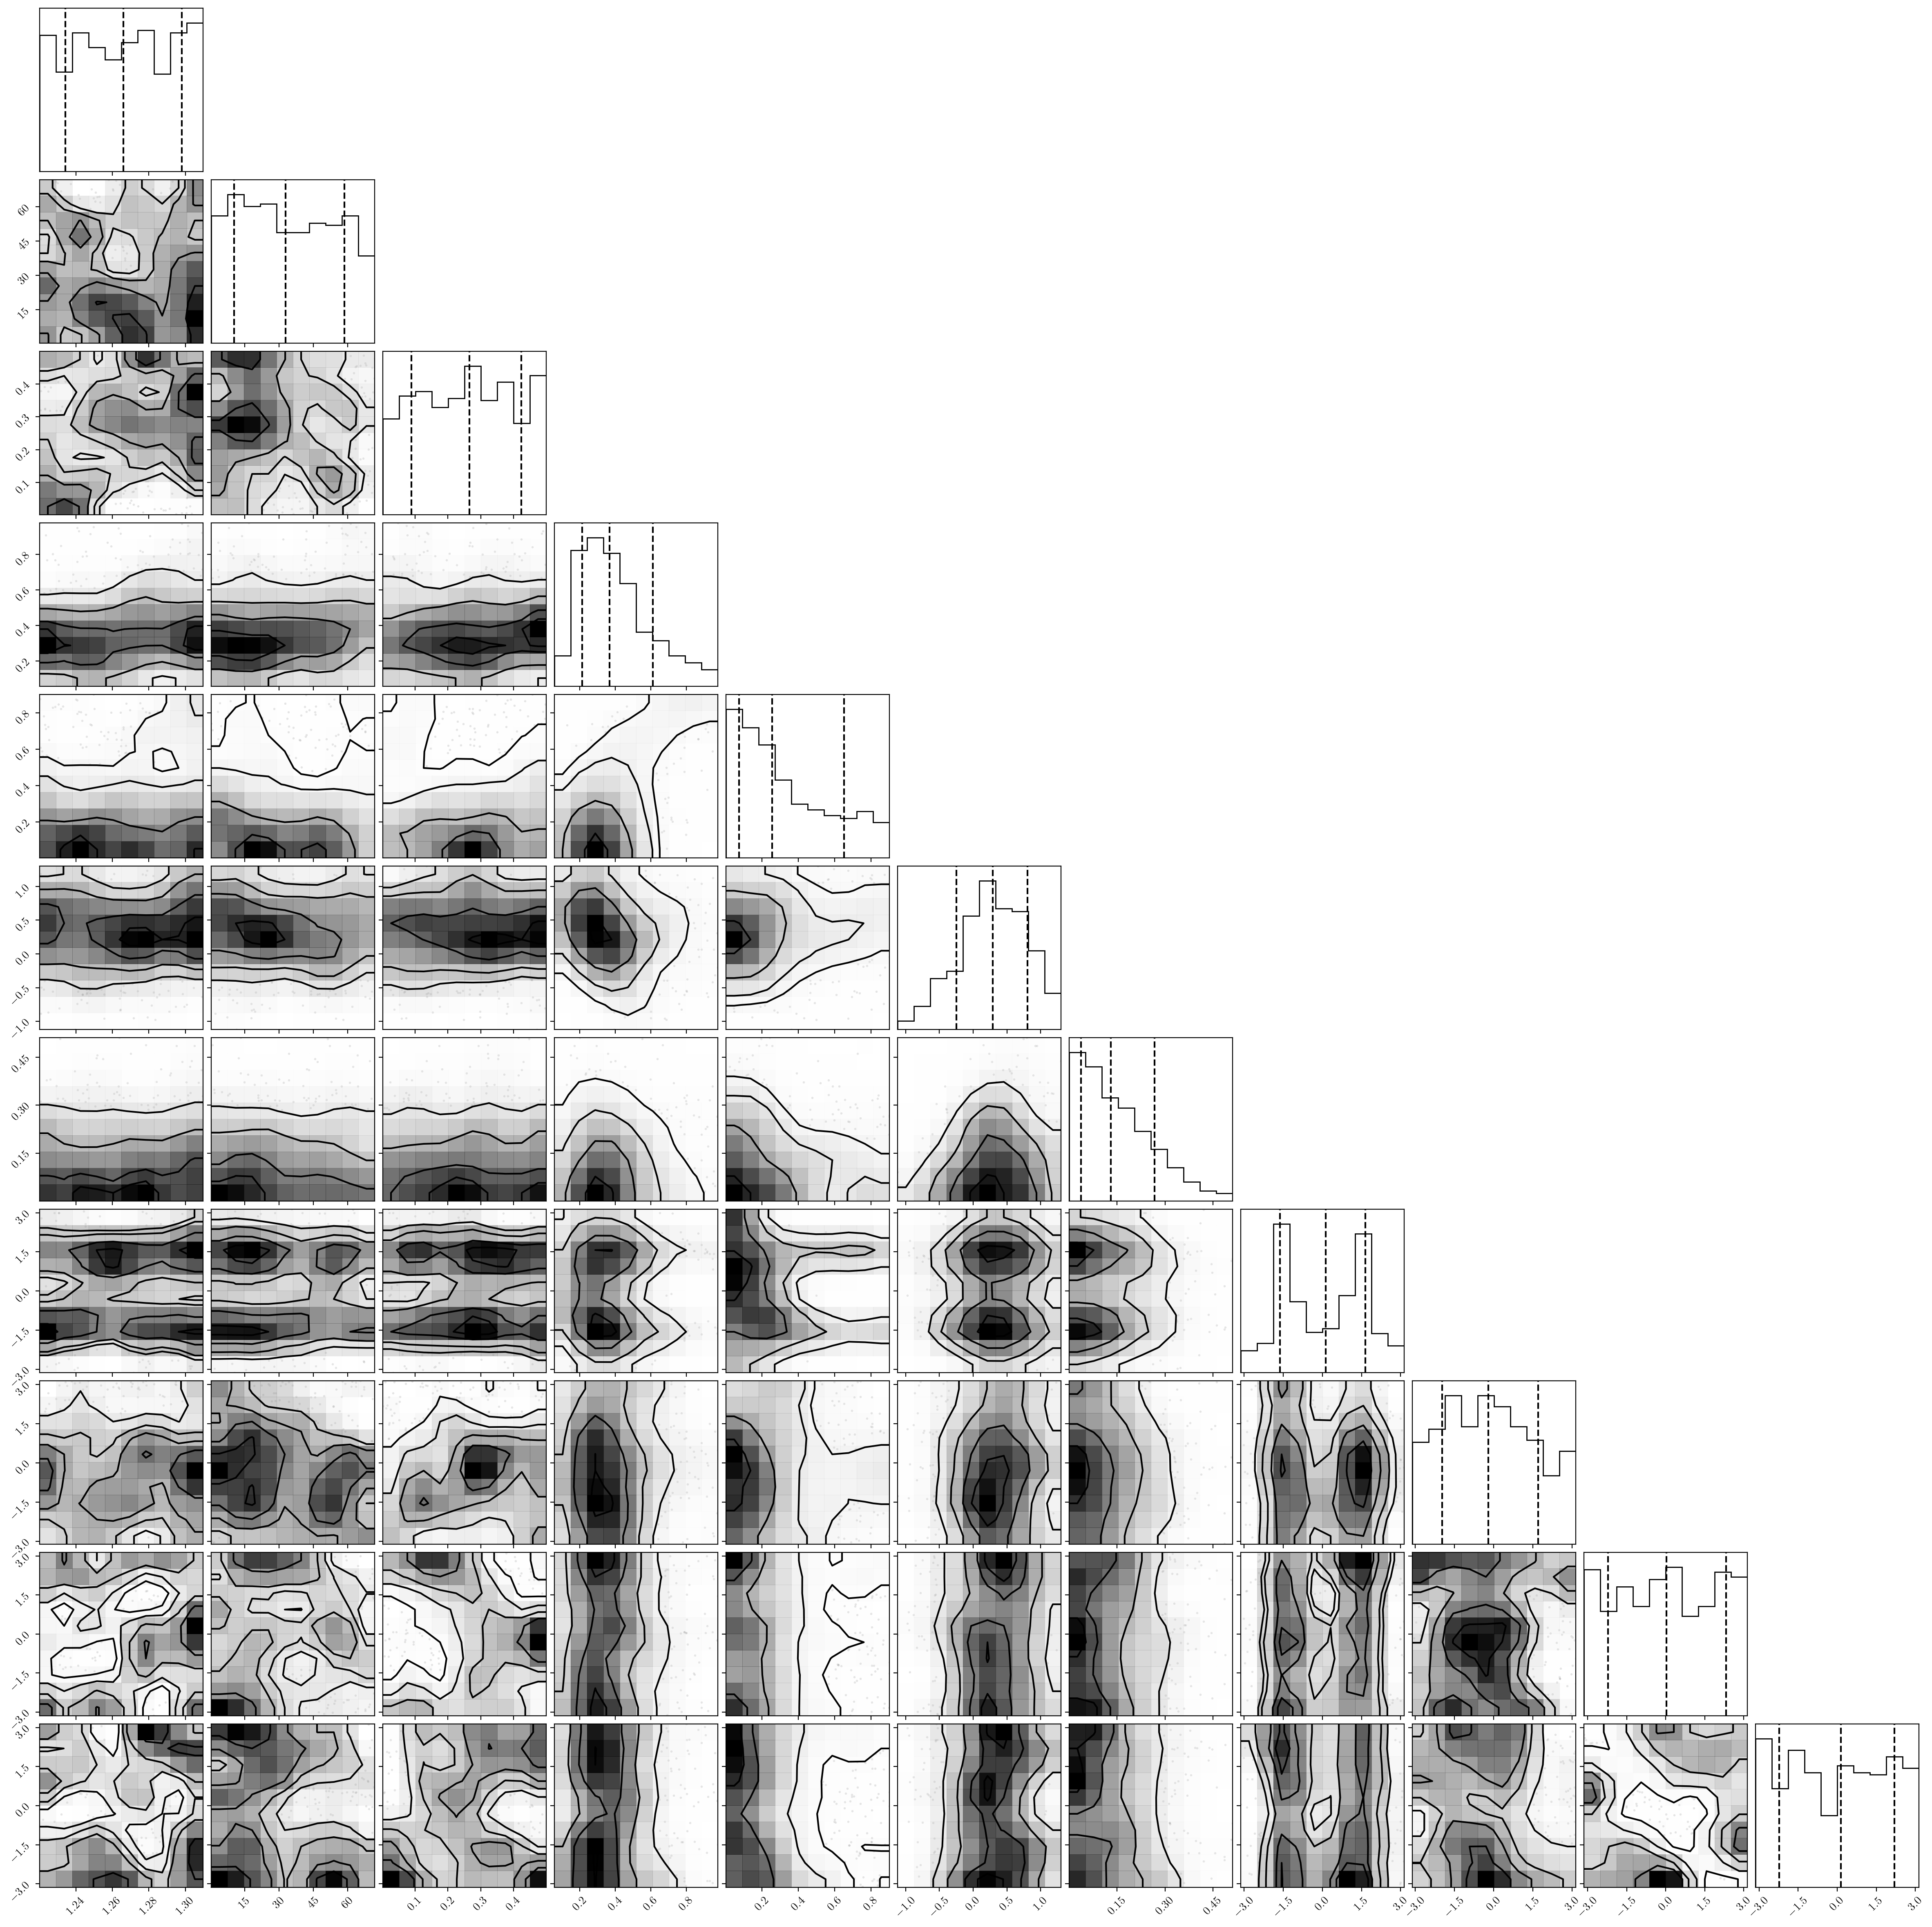

In [18]:
corner.corner(arr_t[arr_t[:, 0]==1, :][: ,idxs], bins=10, smooth=1,
             quantiles=[0.16, 0.5, 0.84])

(array([183., 182., 201., 204., 193., 202., 216., 191., 207., 220.]),
 array([-1.29832508, -1.15095388, -1.00358267, -0.85621147, -0.70884026,
        -0.56146906, -0.41409785, -0.26672664, -0.11935544,  0.02801577,
         0.17538697]),
 <BarContainer object of 10 artists>)

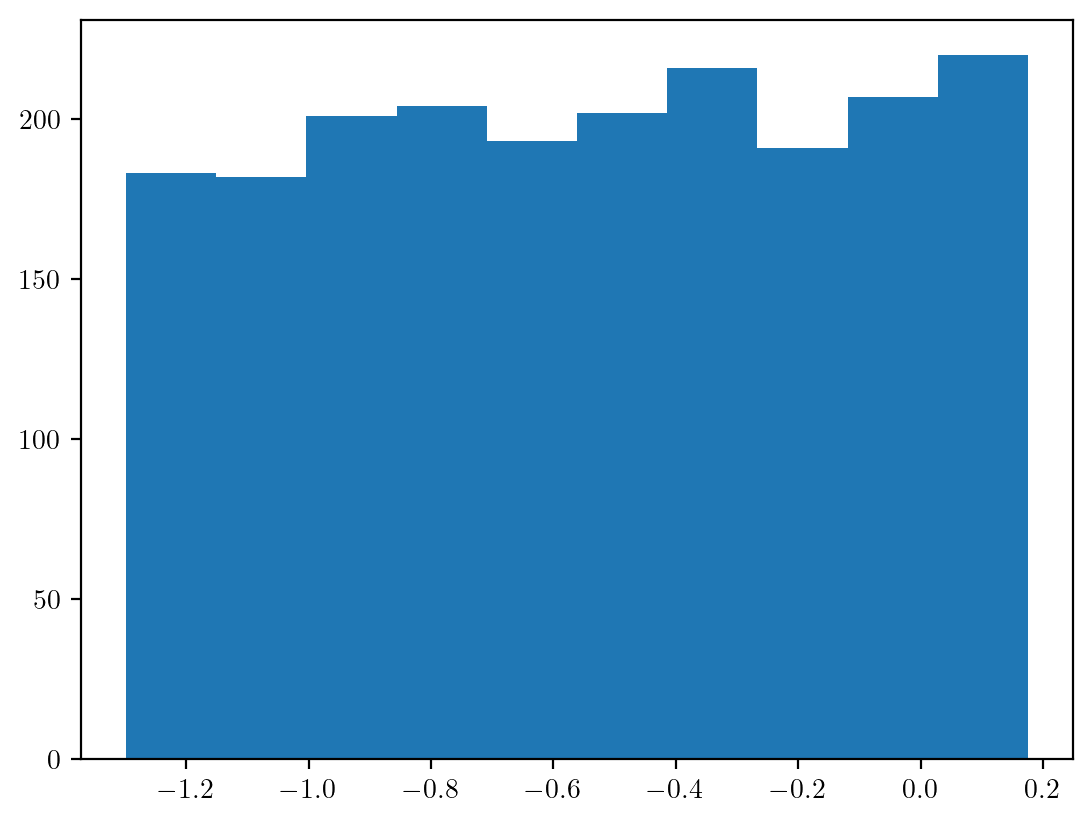

In [17]:
plt.hist(np.log((arr_t[:, keys=="4/a"]/run_systems[system_idx]["gap"][0]/(run_systems[system_idx]["gap"][1]/run_systems[system_idx]["gap"][0]))))

In [8]:
cfg

{'binary': {'m1': 1.4174066404497114,
  'm2': 17.63631592117743,
  'd': 5.337561241515296e-06,
  'e': 0.737884651228494,
  'a': 0.01975727809925341,
  'e_sys': 0.9352747656468796,
  'phase': -1.318269092232089,
  'Omega': 1.4883494906038726,
  'inc': -1.8740665642871266,
  'bin_inc': -2.9297487354745217},
 'n_secondary': 7,
 'secondary_0': {'m': 1.3859429398522658,
  'a': 0.011538051110125822,
  'e': 0.004968689426819055,
  'inc': 0.0,
  'omega': -1.175762302336704,
  'Omega': 1.7532208310128308},
 'secondary_1': {'m': 1.2776937155499062,
  'a': 0.015909280954234762,
  'e': 0.0064678829484959835,
  'inc': 0.0,
  'omega': -2.114658672483245,
  'Omega': -2.921013128947556},
 'n_log': 1000,
 'integrator': 'leapfrog',
 'dt': 0.0001,
 't_end': 10000,
 'name': 'bin_inj/TRAPPIST-1/1999',
 'm_star': 0.7803572343642271,
 'secondary_2': {'m': 0.3806688724678131,
  'a': 0.02235068546864361,
  'e': 0.008048396050070065,
  'inc': 0.0,
  'omega': 1.978584203220998,
  'Omega': -2.31186150327157},
 's

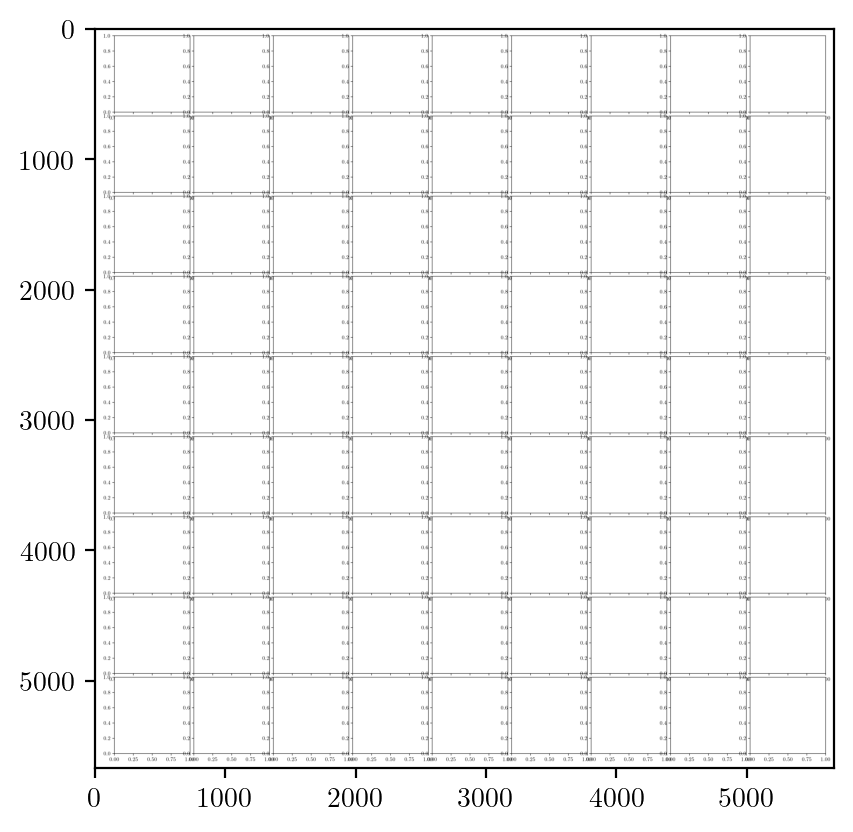

In [9]:
plt.imshow(mpimg.imread('../figs/corner_KOI-351_pmar_scat_None.png'))

In [10]:
arr[stable, :][:, idxs].shape

(0, 11)

In [11]:
idxs = np.array([("inc" not in key) and ("/e" not in key) for key in keys])



param_labels = np.char.replace(np.array(keys)[idxs], "_", "-")



# labels of the populations
listlablpopl = ['stable', 'not stable']

# number of populations
numbpopl = len(listlablpopl)


# number of features
numbfeat = np.sum(idxs)

# generate samples


# labels of the parameters
listlablpara = []
for k in range(numbfeat):
    listlablpara.append([param_labels[k], ''])

typepgrp = 'both'
    
j 
tdpy.plot_grid( [arr[stable, :][: ,idxs][:, :j], arr[np.logical_not(stable),:][:,idxs][:, :j]], listlablpara[:j], listlablpopl=listlablpopl, typeplottdim='scat', pathbase="../figs/corner")
# plt.savefig("../figs/corner.pdf")
# plt.show()

/storage1/fs1/tansu/Active/Wolf_binary-planets/binary_planets/scripts/../tdpy/util.py:3785: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if strgextn is not '':
/storage1/fs1/tansu/Active/Wolf_binary-planets/binary_planets/scripts/../tdpy/util.py:3785: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if strgextn is not '':
/storage1/fs1/tansu/Active/Wolf_binary-planets/binary_planets/scripts/../tdpy/util.py:3785: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if strgextn is not '':


TypeError: 'NoneType' object is not subscriptable

In [16]:
import matplotlib
matplotlib.colors.to_rgba(listcolrpopl[1], 0.2)

(0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2)

In [12]:
matplotlib.colors.to_rgba(listcolrpopl[u], 0.2))

SyntaxError: unmatched ')' (1798423642.py, line 1)

In [ ]:
c = dict(cfg)
id(c)

In [ ]:
c["name"]

In [ ]:
cfg["name"] = "test"

In [6]:
run_systems = np.load("../data/compact_systems_run_composite.npy", allow_pickle=True)
names = [sys["name"] for sys in run_systems]

In [7]:
np.where(np.array(names) == "TOI-561")

(array([63]),)

In [5]:
names

['Kepler-342']